# Data Analisis Assignment - Group 1
## Introduction
The goal of this project is to analyze hourly electricity generation in Spain, broken down by autonomous community and generation technology. We aim to extract and explore key insights from the data, identify regional and technological trends, and optionally examine correlations between different data sources.
## Task 1: Data Extraction and Saving
The data extraction process is carried out through the Red Eléctrica de España (REE) API. An interactive user interface allows users to input the desired autonomous community, time period, and generation technology. Based on these inputs, the program retrieves the corresponding hourly electricity generation data and exports it to an Excel file named in the format: "Generation_[AutonomousCommunity][StartDate][EndDate]".

__Inputs:__
- Region Code
- Technology
- Start Date
- End Date

__Output:__
- Excel file with columns: datetime, value by technology, percentage value by technology

In [2]:
import requests
import json
import pandas as pd
from datetime import datetime as dt

# Geo_id per region according to the REE API:
# https://www.ree.es/es/datos/apidatos
# ───────────────────────────────────────────────────────────────────────────
# 1. Dictionary REGIONS  →  readable key  →  API id
# ───────────────────────────────────────────────────────────────────────────
REGIONES = {
    "Andalucía": 4,
    "Aragón": 5,
    "Cantabria": 6,
    "Asturias": 11,
    "Castilla y León": 8,
    "Castilla-La Mancha": 7,
    "Cataluña": 9,
    "Comunidad Valenciana": 15,
    "Extremadura": 16,
    "Galicia": 17,
    "Madrid": 8752,
    "Murcia": 21,
    "Navarra": 14,
    "País Vasco": 10,
    "La Rioja": 20,
    "Islas Baleares": 8743,
    "Islas Canarias": 8742,
    "Ceuta": 8744,
    "Melilla": 8745,
    "Península": 8741,
}

# ───────────────────────────────────────────────────────────────────────────
# 2. Interactive selection (region + dates)
# ───────────────────────────────────────────────────────────────────────────
print("╔══════════════════════════════════════════╗")
print("║   Available Regions (geo_limit=ccaa)     ║")
print("╚══════════════════════════════════════════╝")

for n, reg in enumerate(REGIONES, 1):
    print(f"{n:>2}. {reg}")

# --- Select region ---
while True:
    try:
        idx = int(input("\nNumber of desired region: "))
        region_name = list(REGIONES)[idx - 1]
        geo_id = REGIONES[region_name]
        break
    except (ValueError, IndexError):
        print("⛔ Invalid choice, try again…")

# --- Date input ---
def ask_date(prompt):
    while True:
        try:
            txt = input(prompt)
            return dt.strptime(txt.strip(), "%Y-%m-%d %H:%M")
        except ValueError:
            print("⛔ Invalid format. Example: 2019-01-01 00:00")

start = ask_date("\nStart date (YYYY-MM-DD HH:MM): ")
end   = ask_date("End date   (YYYY-MM-DD HH:MM): ")
if end <= start:
    raise ValueError("End date must be after the start date.")

print(f"\n▶ Region: {region_name}  (geo_id = {geo_id})")
print(f"▶ Period: {start}  →  {end}\n")

# ───────────────────────────────────────────────────────────────────────────
# 3. API call function (daily granularity)
# ───────────────────────────────────────────────────────────────────────────
def get_gen(geo_id, start_date, end_date):
    url = "https://apidatos.ree.es/es/datos/generacion/estructura-generacion"

    headers = {
        "Accept": "application/json",
    }

    params = {
        "start_date": start_date,
        "end_date": end_date,
        "time_trunc": "day",
        "geo_limit":  "ccaa",
        "geo_id": geo_id
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"⛔ Error {response.status_code}")
        print(response.text)
        return pd.DataFrame()  # <- Return empty DataFrame on failure

    data = response.json()

    # Extract generation data
    rows = []
    for technology in data["included"]:
        name = technology["attributes"]["title"]
        for v in technology["attributes"]["values"]:
            rows.append({
                "datetime": v["datetime"],
                "value": v["value"],
                "percentage": v["percentage"],
                "technology": name
            })

    return pd.DataFrame(rows)

# Call API
df = get_gen(geo_id, start, end)


if df.empty:
    print("❗ No data found. Please verify your input.")
else:
    print(df.head())
    # Format dates to string
    start_str = start.strftime("%Y%m%d")
    end_str   = end.strftime("%Y%m%d")

    # Export to Excel
    archivo_excel = f"generacion_{region_name.replace(' ', '_').lower()}_{start_str}_{end_str}.xlsx"
    df.to_excel(archivo_excel, index=False)
    print(f"✅ Data saved to: {archivo_excel}")

╔══════════════════════════════════════════╗
║   Available Regions (geo_limit=ccaa)     ║
╚══════════════════════════════════════════╝
 1. Andalucía
 2. Aragón
 3. Cantabria
 4. Asturias
 5. Castilla y León
 6. Castilla-La Mancha
 7. Cataluña
 8. Comunidad Valenciana
 9. Extremadura
10. Galicia
11. Madrid
12. Murcia
13. Navarra
14. País Vasco
15. La Rioja
16. Islas Baleares
17. Islas Canarias
18. Ceuta
19. Melilla
20. Península



Number of desired region:  1

Start date (YYYY-MM-DD HH:MM):  2021-02-25 00:00
End date   (YYYY-MM-DD HH:MM):  2021-03-25 00:00



▶ Region: Andalucía  (geo_id = 4)
▶ Period: 2021-02-25 00:00:00  →  2021-03-25 00:00:00

                        datetime       value  percentage  technology
0  2021-02-25T00:00:00.000+01:00  191711.084    0.273575  Hidráulica
1  2021-02-26T00:00:00.000+01:00  189906.439    0.269352  Hidráulica
2  2021-02-27T00:00:00.000+01:00  157463.141    0.217900  Hidráulica
3  2021-02-28T00:00:00.000+01:00  135545.318    0.190929  Hidráulica
4  2021-03-01T00:00:00.000+01:00  157149.651    0.006980  Hidráulica
✅ Data saved to: generacion_andalucía_20210225_20210325.xlsx


## Task 3: Data Visualization and Insights Extraction

This code transforms raw time-series (hourly or daily) data into insightful visualizations by aggregating daily generation values by different time periods (day, week, month, year) and demonstating them by technology type. 

__Inputs:__
- Excel File "Generation_[AutonomousCommunity][StartDate][EndDate]"

## To-dos for Taks 3: 

~~Quitar Generacion Total de la lista antes de hacer graphs
Something is wrong with the 1st or last day of the month or the range - looks like it is showing monthly aggregated value maybe, but why?~~

### Current issues:
- %age bar chart: on the 1st of month the % doesn't add up to 100%
- in line chart, for Generacion total only it's weird - 0% for all values, and only non-0 value on 1 of month

### Current charts:
~~Bar chart, each bar is date, made up of technologies
Repeated for %~~

Can try: Pivot this table and do it for 1 tech only, showing production for each day 
Repeat for %

### Upgrade the code: 
Wrap up into a generalized function that lets you pick the aggregation level upfront: "day", "week", "month", or "year”. 
Edit code so it asks for just month and just year, or just truncate it like daily/weekly code does now (and include only full week/mo/year)

~~### added to Yan's original code:
import matplotlib.pyplot as plt
The following sums values for the whole day, in case hourly data becomes available in this API in the future
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))   — so the Legend is not in the middle of the plot~~

In [ ]:
# Daily Energy Generation Bar Graph by Technology
# exclusive of last date in range
# It goes from 01 to 23h by month. Check the range of dates available in the API
# This sums hourly values for each day, in case hourly data becomes available in this widget in the future

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum values, which are the larger of two values for each tech on the 1st of the month
# Sort so that the larger values come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "value"], ascending=[True, True, True])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

pivot_df = df_clean.pivot_table(
    index="date",
    columns="technology",
    values="value",
    aggfunc="sum", 
    fill_value=0
    )

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Daily generation by technology in Spain",
    )

plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
# Daily Energy Generation Percentage Bar Graph by Technology
# exclusive of last date in range
# It goes from 01 to 23h by month. Check the range of dates available in the API
# This sums hourly percentages for each day, in case hourly data becomes available in this widget in the future

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum percentages, which are the larger of two values for each tech on the 1st of the month
# Sort so that the larger percentages come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "percentage"], ascending=[True, True, False])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

pivot_df = df_clean.pivot_table(
    index="date",
    columns="technology",
    values="percentage",
    aggfunc="sum", 
    fill_value=0
    )

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Daily generation percentage by technology in Spain",
    )

plt.xlabel("Date")
plt.ylabel("Generation (%)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


/var/folders/ys/tjkh6d2s1r1_ccrzxvfzc7f80000gn/T/ipykernel_93166/1371620242.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")


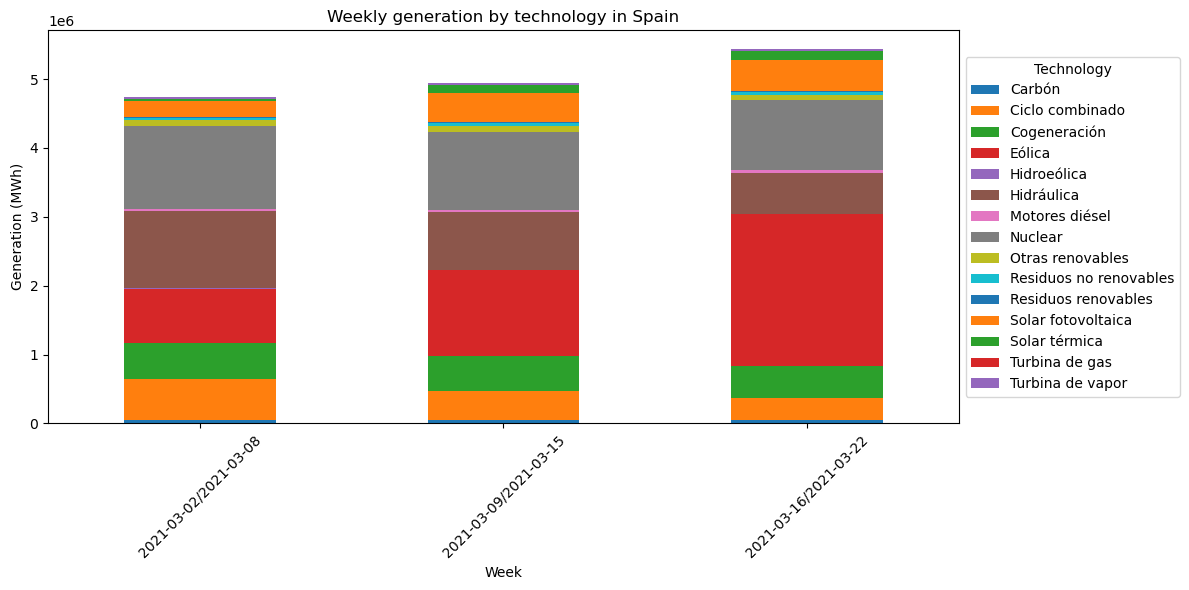

In [5]:
import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum values, which are the larger of two values for each tech on the 1st of the month
# Sort so that the larger values come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "value"], ascending=[True, True, True])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

# Add weekly period starting on Monday
df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")

# Count number of days per week
week_counts = df_clean.groupby("week")["date"].nunique()
full_weeks = week_counts[week_counts == 7].index

# Keep only data from full weeks
df_clean = df_clean[df_clean["week"].isin(full_weeks)]

# Pivot the cleaned dataframe
pivot_df = df_clean.pivot_table(
    index="week",
    columns="technology",
    values="value",
    aggfunc="sum", 
    fill_value=0
)

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Weekly generation by technology in Spain",
)

plt.xlabel("Week")
plt.ylabel("Generation (MWh)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

/var/folders/ys/tjkh6d2s1r1_ccrzxvfzc7f80000gn/T/ipykernel_93166/2581865621.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")


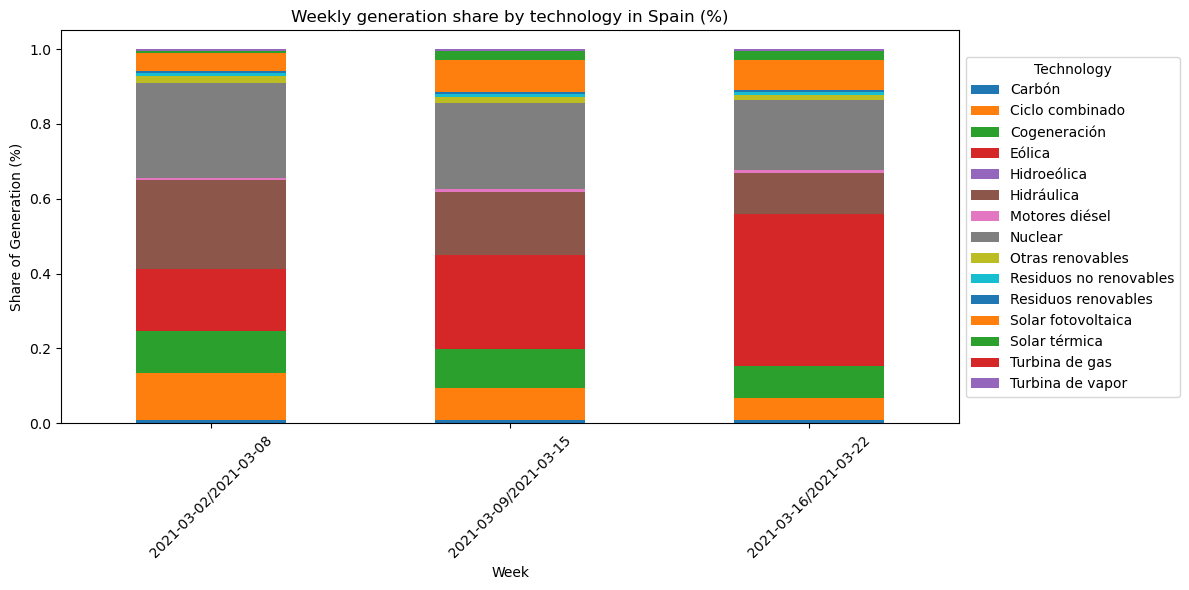

In [6]:
# Weekly Energy Generation Share Bar Graph by Technology (Percentage)
# exclusive of last date in range
# This aggregates percentage values for complete weeks only (starting on Mondays)

import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Remove all rows corresponding to the last date in the dataset (the values are abnormally low)
df_truncated = df[df["date"] != df["date"].max()]

# Remove monthly sum percentages, which are the larger of two values for each tech on the 1st of the month
# Sort so that the larger percentages come last, and keep only the first
df_truncated = df_truncated.sort_values(["technology", "date", "percentage"], ascending=[True, True, False])
df_clean = df_truncated.drop_duplicates(subset=["date", "technology"], keep="first")

# Add weekly period starting on Monday
df_clean["week"] = pd.to_datetime(df_clean["date"]).dt.to_period("W-MON")

# Count number of days per week
week_counts = df_clean.groupby("week")["date"].nunique()
full_weeks = week_counts[week_counts == 7].index

# Keep only data from full weeks
df_clean = df_clean[df_clean["week"].isin(full_weeks)]

# Pivot the cleaned dataframe
pivot_df = df_clean.pivot_table(
    index="week",
    columns="technology",
    values="percentage",
    aggfunc="mean", 
    fill_value=0
)

pivot_df_indiv = pivot_df.drop(columns="Generación total", errors="ignore")

pivot_df_indiv.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title=f"Weekly generation share by technology in Spain (%)",
)

plt.xlabel("Week")
plt.ylabel("Share of Generation (%)")
plt.xticks(rotation=45)
plt.legend(title="Technology", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
# Daily Energy Generation Line Charts by Technology
# This script lets the user select a technology from the dataset and shows two line charts:
# one for daily total production (in MWh) and one for average daily percentage.
# It groups and sums values by day to visualize trends over time.

import pandas as pd
import matplotlib.pyplot as plt

# Convert 'datetime' column to datetime type
df["date"] = pd.to_datetime(df["datetime"]).dt.date

# Get unique technologies and create the dynamic menu
tech_list = sorted(df['technology'].unique())

df_trunc = df[df["date"] != df["date"].max()]

df_trunc_val = df_trunc.sort_values(["technology", "date", "value"], ascending=[True, True, True])
df_trunc_val = df_trunc_val.drop_duplicates(subset=["date", "technology"], keep="first")

df_trunc_perc = df_trunc.sort_values(["technology", "date", "percentage"], ascending=[True, True, False])
df_trunc_perc = df_trunc_perc.drop_duplicates(subset=["date", "technology"], keep="first")

# Menu and input loop
selected_tech = None
while selected_tech is None:
    print("\nSelect a technology to generate the chart:\n")
    for idx, tech in enumerate(tech_list, start=1):
        print(f"{idx}. {tech}")

    user_input = input("\nEnter the number of the selected technology: ")
    try:
        choice = int(user_input)
        if 1 <= choice <= len(tech_list):
            selected_tech = tech_list[choice - 1]
        else:
            print("Number out of range. Please try again.")
    except ValueError:
        print("Invalid input. Please enter a number.")

print(f"\nYou selected: {selected_tech}")

df_val_filtered = df_trunc_val[df_trunc_val['technology'] == selected_tech]
df_perc_filtered = df_trunc_perc[df_trunc_perc['technology'] == selected_tech]

grouped_val = df_val_filtered.groupby('date')['value'].sum().reset_index()
grouped_perc = df_perc_filtered.groupby('date')['percentage'].mean().reset_index()

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(grouped_val['date'], grouped_val['value'], marker='o')
plt.title(f'Daily Production - {selected_tech}')
plt.ylabel('Production (MWh)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(grouped_perc['date'], grouped_perc['percentage'], marker='o', color='orange')
plt.title(f'Daily Share of Total Production - {selected_tech}')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()

## Task 2: Data Preprocessing and Cleaning 

__Inputs:__
- Excel File "Generation_[AutonomousCommunity][StartDate][EndDate]"

In [ ]:
# Code to read the Excel file with Pandas and store it in a Pandas Dataframe
# *Insert Code here*

In [ ]:
# Display the top 5 rows of the Dataframe 
# *insert code here data.head()*

In [ ]:
# Display information about the data including the index dtype and columns, non-null values and memory usage
# *Insert code here: data.info()*

In [ ]:
# Display descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.
# *insert code here data.discribe()*

In [ ]:
# Check data for missing values
# *insert code here, Use .isnull().sum() (Python) to see which columns have missing data. Output can be a sentence like: No null values found; or if there are some how they were treated*

In [ ]:
# Check data for outliers values
# *insert code here, Use boxplots, z-scores, or IQR to look which columns have outliers in the data. Output can be a sentence like: No outliers found; or if there are some how they were treated*

In [ ]:
# Check data for dublicate values
# *insert code here, Use .duplicated() to identify and .drop_duplicates() to remove them. Output can be a sentence like: No dublicates found; or if there are some how they were treated*

## Task 4: Comparison of the results of the different sources

__Inputs:__
- Data of Red Eléctrica de España (REE) API
- Wind data from maritime observations in NOOA corresponding to the Spanish coasts (Group 4)